In [58]:
import numpy as np
from PIL import Image as im
import pandas as pd
import os
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import itertools as it
import seaborn as sns
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing import image

# Load dataset and Summary

In [2]:
# the array is saved in the file Images.npy 
train_Data = np.load('train_Images.npy')
test_Data = np.load('test_Images.npy')

In [3]:
train_labels=pd.read_csv('train_labels.csv')
test_labels=pd.read_csv('test_labels.csv')

### Shape of the Dataset

In [21]:
# Shape of the Train_Data
print("Shape of the Train Data{}".format(train_Data.shape))

Shape of the Train Data(8804, 256, 256, 3)


In [22]:
# Shape of the Test_Data
print("Shape of the Test Data{}".format(test_Data.shape))

Shape of the Test Data(2592, 256, 256, 3)


In [24]:
train_labels.shape

(8804, 1)

In [25]:
test_labels.shape

(2592, 1)

* We have 8804 images in the Train Dataset
* And 2592 Images in the Test Dataset
* Each image is of size (256,256,3) 
* All the images have 3 channels(RGB)

## Number of Classes

In [26]:
num_classes=len(pd.unique(train_labels['Label']))
print("Number of Classes",num_classes)

Number of Classes 10


In [28]:
label=pd.unique(train_labels['Label'])
for i,l in enumerate(label):
    print(i+1,":",l)

1 : Tomato___Bacterial_spot
2 : Peach___Bacterial_spot
3 : Potato___Late_blight
4 : Grape___Black_rot
5 : Apple___Black_rot
6 : Tomato___healthy
7 : Apple___healthy
8 : Grape___healthy
9 : Peach___healthy
10 : Potato___healthy


* We have 10 classes in our Dataset which is listed above

# Prepare the Data for Training

## Proportion of Images in Each Class

<AxesSubplot:title={'center':'Proportion of Images'}>

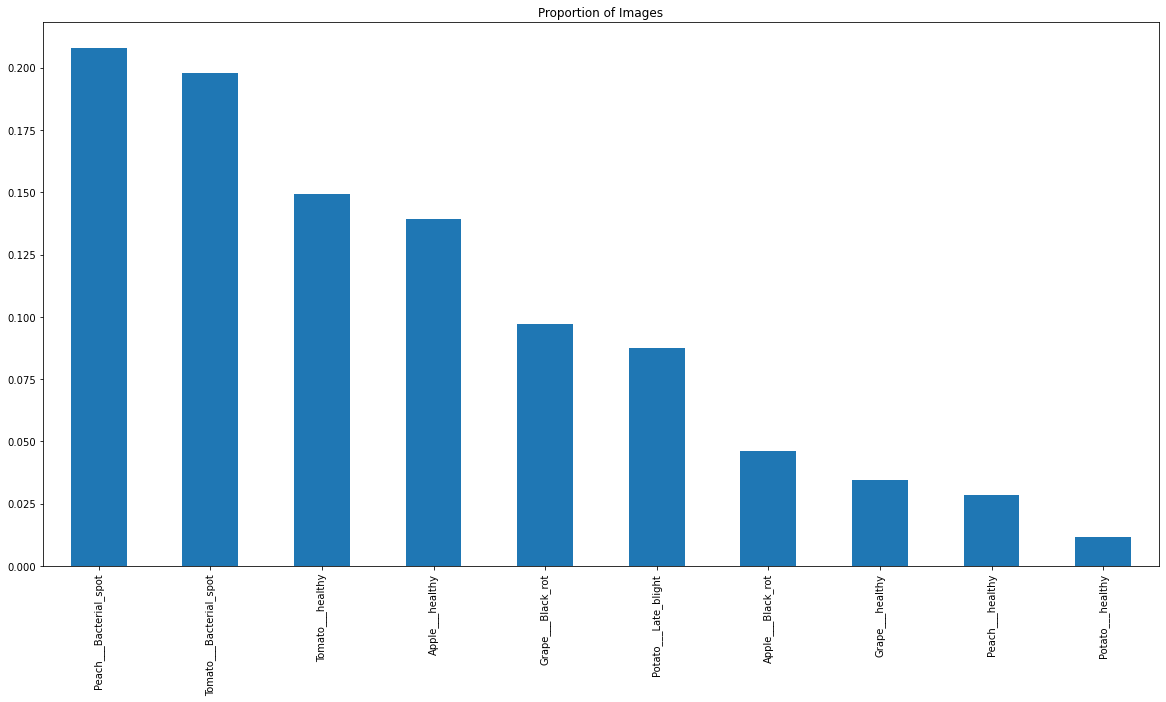

In [81]:
train_labels.Label.value_counts(normalize=True).plot(kind='bar',title = "Proportion of Images")

<AxesSubplot:title={'center':'Proportion of Images'}>

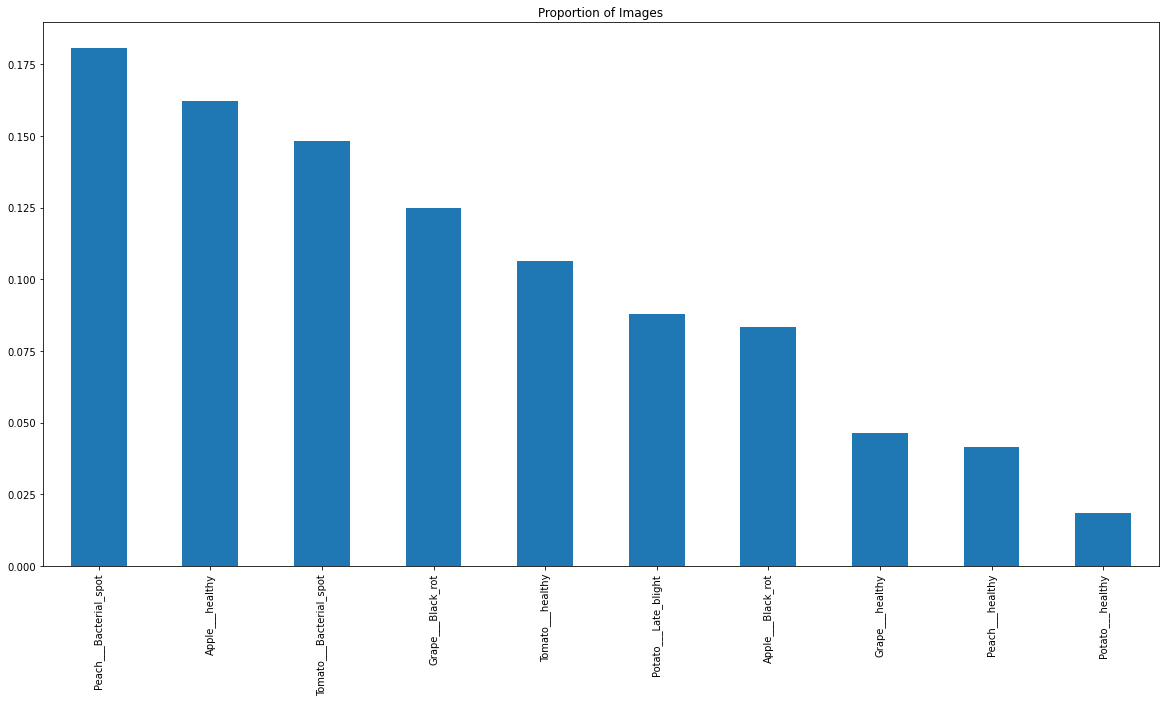

In [82]:
test_labels.Label.value_counts(normalize=True).plot(kind='bar',title = "Proportion of Images")

# Number of Images for Each Class in Train Dataset

In [83]:
Categories=['Tomato___Bacterial_spot','Peach___Bacterial_spot','Potato___Late_blight','Grape___Black_rot','Apple___Black_rot',
            'Tomato___healthy','Apple___healthy','Grape___healthy','Peach___healthy','Potato___healthy']
NUM_CATEGORIES=len(Categories)
train_Dir='Dataset/train'
for category in Categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_Dir, category)))))

Tomato___Bacterial_spot 1743 images
Peach___Bacterial_spot 1829 images
Potato___Late_blight 772 images
Grape___Black_rot 856 images
Apple___Black_rot 405 images
Tomato___healthy 1315 images
Apple___healthy 1225 images
Grape___healthy 303 images
Peach___healthy 252 images
Potato___healthy 104 images


# Similarly for Test Data

In [85]:
test_Dir='Dataset/test'
for category in Categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(test_Dir, category)))))

Tomato___Bacterial_spot 384 images
Peach___Bacterial_spot 468 images
Potato___Late_blight 228 images
Grape___Black_rot 324 images
Apple___Black_rot 216 images
Tomato___healthy 276 images
Apple___healthy 420 images
Grape___healthy 120 images
Peach___healthy 108 images
Potato___healthy 48 images


In [86]:
## Make a Read Image Function
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [87]:
data_dir='Dataset'

## Ploting the Images

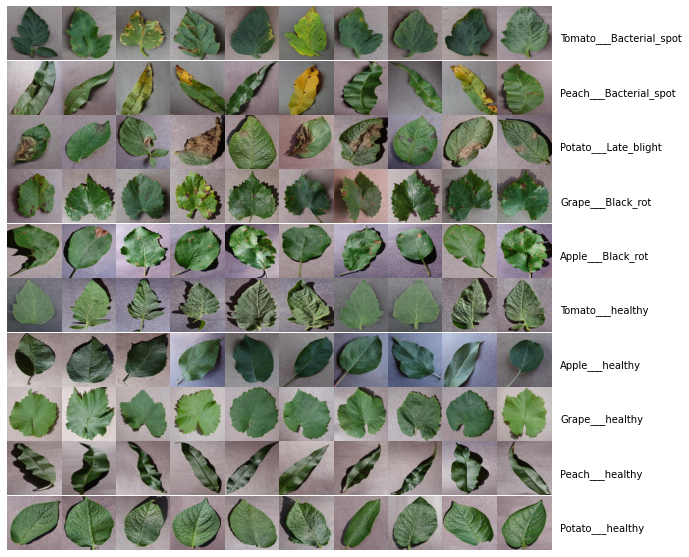

In [88]:
fig = plt.figure(2, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.005)
i = 0
for category_id, category in enumerate(Categories):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (256, 256))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(300, 150, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

# Data Pre-Processing

## Remove unwanted noise from the images using Guassian Blurring
The Gaussian blur feature is obtained by blurring (smoothing) an image using a Gaussian function to reduce the noise level.
It can be considered as a nonuniform low-pass filter that preserves low spatial frequency and reduces image noise and negligible details in an image. It is typically achieved by convolving an image with a Gaussian kernel. This Gaussian kernel in 2-D form is expressed as

In [89]:
train_Blurred=[]
valid_Blurred=[]

In [90]:
kernelSizes = (3, 3)
# loop over the kernel sizes and apply a "Gaussian" blur to the image
for Image in train_Data:
    train_Blurred.append(cv2.GaussianBlur(Image, kernelSizes, 0))
for Image in test_Data:
    valid_Blurred.append(cv2.GaussianBlur(Image, kernelSizes, 0))

## Apply the Normalization 
Image Normalization is a process in which we change the range of pixel intensity values to make the image more familiar or normal to the senses, hence the term normalization. Often image normalization is used to increase contrast which aids in improved feature extraction or image segmentation.


Image Normalization is used to remove noise from the picture (data). With the help of Image Normalization, we can remove high-frequency noise and very low noise from the image which is really helpful. When we look at an image that is unclear to our senses, it becomes stressful for our eyes. But with the help of Image Normalization, we bring the image into a range of intensity values which is normal to our senses and hence we do not have to stress our visual senses and can clearly understand what is going on in an image. Whenever an image gets a poor contrast due to any reason our aim is to fix the contrast of the image so that it is normal to our senses.

In a normalized image:

* Mean = 0
* Variance = 1

In [91]:
train_Pre_Process_Dataset=[]
valid_Pre_Process_Dataset=[]
norm_img=np.zeros((256,256))
for Image in train_Blurred:
    train_Pre_Process_Dataset.append(cv2.normalize(Image,  norm_img, 0, 255, cv2.NORM_MINMAX))
for Image in valid_Blurred:
    valid_Pre_Process_Dataset.append(cv2.normalize(Image,  norm_img, 0, 255, cv2.NORM_MINMAX))

## Plot the images before and after the pre-processing steps ( Blurring & Normalization ) 

### Images before Pre-processing steps ( Blurring & Normalization )

<function matplotlib.pyplot.show(close=None, block=None)>

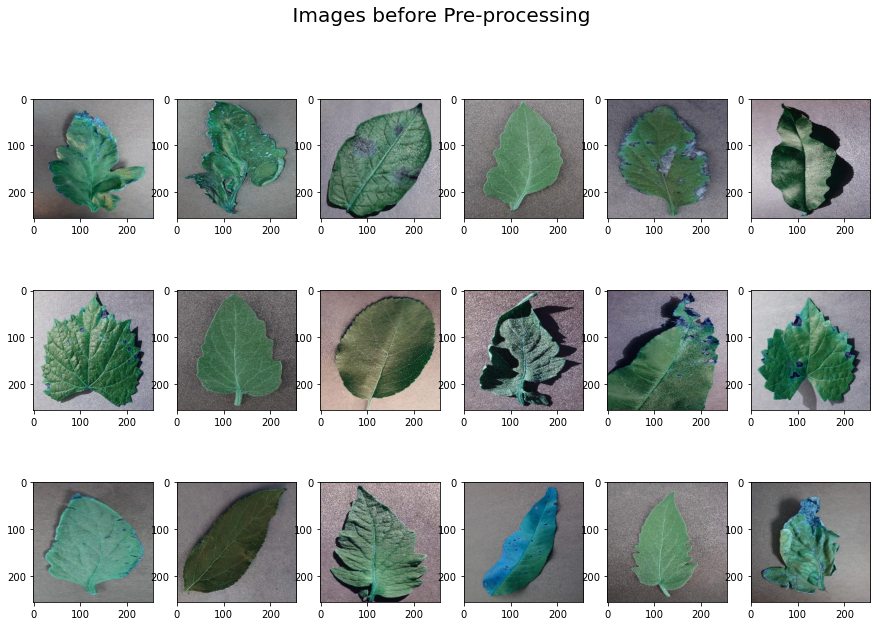

In [94]:
fig, ax = plt.subplots(nrows=3, ncols=6,figsize=(15,10))
a=0
fig.suptitle(' Images before Pre-processing', fontsize=20)
for i in range(18):
    image = train_Data[a]
    ax.flatten()[i].imshow(image)
    a=a+250
plt.show

### Images after Pre-processing steps ( Blurring & Normalization )

<function matplotlib.pyplot.show(close=None, block=None)>

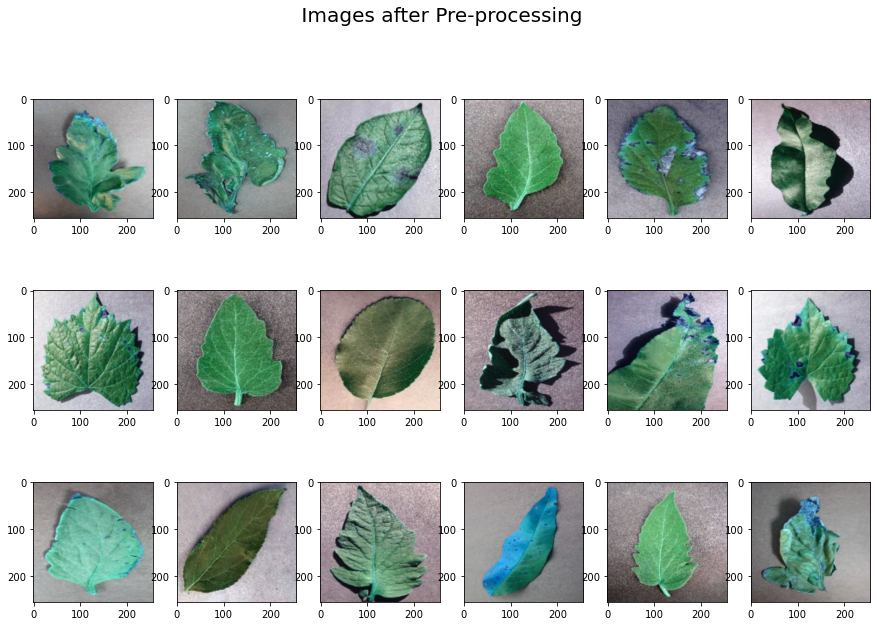

In [97]:
fig, ax = plt.subplots(nrows=3, ncols=6,figsize=(15,10))
a=0
fig.suptitle(' Images after Pre-processing', fontsize=20)
for i in range(18):
    image = train_Pre_Process_Dataset[a]
    ax.flatten()[i].imshow(image)
    a=a+250
plt.show

After **Pre-Procesing** the change is quite evident. When you compare it with the Images before pre-processing, you can notice that it is far clearer and has better contrast.

# One Hot-Encoding
One hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions. One hot encoding is a crucial part of feature engineering for machine learning

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')
# transform data
Y_train = enc.fit_transform(train_labels[['Label']]).toarray()
Y_valid = enc.fit_transform(test_labels[['Label']]).toarray()

In [9]:
X_train=np.asarray(train_Pre_Process_Dataset)
X_valid=np.asarray(valid_Pre_Process_Dataset)

## Print the Shape of the Data and labels

In [10]:
print("X_train shape {}, Y_train shape {},X_Valid shape {}, Y_valid {}.".format(X_train.shape,Y_train.shape,X_valid.shape,Y_valid.shape))

X_train shape (8804, 256, 256, 3), Y_train shape (8804, 10),X_Valid shape (2592, 256, 256, 3), Y_valid (2592, 10).


# ResNet50V2 Model

In [15]:
Resnet_base_model = keras.applications.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

In [16]:
#base_model.summary()

Freezing the Base Model
Before we add our new layers onto the pre-trained model, we should take an important step: freezing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset. If they were unfrozen at this stage, we would likely destroy this valuable information. There will be an option to unfreeze and train these layers later, in a process called fine-tuning.

Freezing the base layers is as simple as setting trainable on the model to False

In [17]:
Resnet_base_model.trainable = False

## Adding New Layers
We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model. First will be a pooling layer like we saw in our earlier convolutional neural network. (If you want a more thorough understanding of the role of pooling layers in CNNs, please read this detailed blog post). We then need to add our final layer, which will classify Bo or not Bo. This will be a densely connected layer with one output.

In [18]:
inputs = keras.Input(shape=(256, 256, 3))
# Separately from setting trainable on the model, we set training to False 
x = Resnet_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes,activation='softmax')(x)
Resnet_model = keras.Model(inputs, outputs)

In [19]:
Resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Compiling the Model
As with our previous exercises, we need to compile the model with loss and metrics options. We have to make some different choices here. In previous cases we had many categories in our classification problem. As a result, we picked categorical crossentropy for the calculation of our loss. In this case we only have a binary classification problem (Bo or not Bo), and so we will use binary crossentropy. Further detail about the differences between the two can found here. We will also use binary accuracy instead of traditional accuracy.

In [21]:
# Important to use Categorical crossentropy as we now have a Categorical classification problem
Resnet_model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [22]:
Resnet_history=Resnet_model.fit(X_train, Y_train, epochs=100, verbose=1,batch_size=10 ,validation_data=(X_valid, Y_valid))

Epoch 1/100
881/881 [==============================] - 43s 46ms/step - loss: 10.9083 - categorical_accuracy: 0.5687 - val_loss: 7.4012 - val_categorical_accuracy: 0.6655
Epoch 2/100
881/881 [==============================] - 39s 44ms/step - loss: 8.0281 - categorical_accuracy: 0.6857 - val_loss: 9.2181 - val_categorical_accuracy: 0.6296
Epoch 3/100
881/881 [==============================] - 39s 45ms/step - loss: 6.2927 - categorical_accuracy: 0.7495 - val_loss: 6.1082 - val_categorical_accuracy: 0.7512
Epoch 4/100
881/881 [==============================] - 39s 45ms/step - loss: 5.7200 - categorical_accuracy: 0.7790 - val_loss: 17.0376 - val_categorical_accuracy: 0.6458
Epoch 5/100
881/881 [==============================] - 39s 45ms/step - loss: 7.2851 - categorical_accuracy: 0.7682 - val_loss: 5.8626 - val_categorical_accuracy: 0.7589
Epoch 6/100
881/881 [==============================] - 40s 45ms/step - loss: 5.8686 - categorical_accuracy: 0.8029 - val_loss: 4.6606 - val_categorical_a

In [27]:
Resnet_model.save('Resnet_model.h5')

C:\Users\Tufail\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Performance of Resnet Model

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


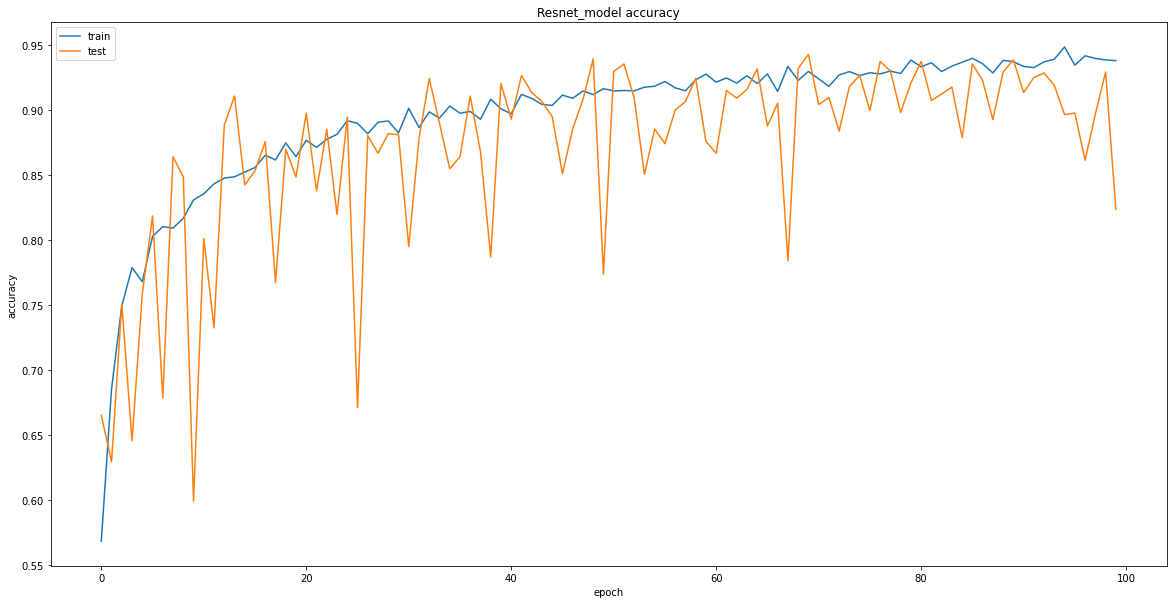

In [23]:
print(Resnet_history.history.keys())
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(Resnet_history.history['categorical_accuracy'])
plt.plot(Resnet_history.history['val_categorical_accuracy'])
plt.title('Resnet_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

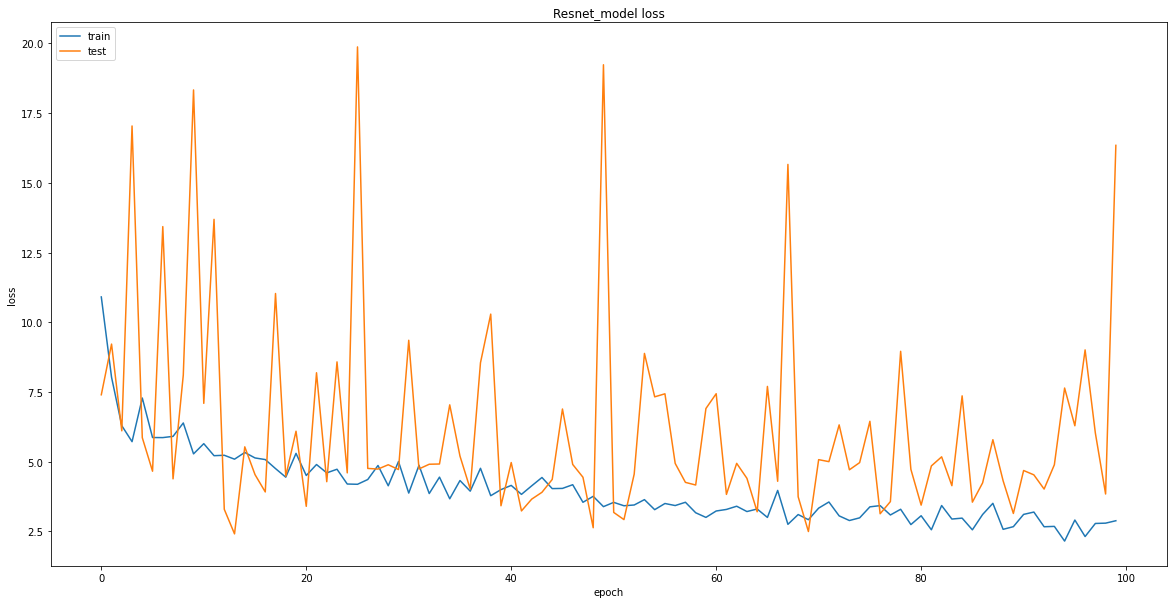

In [24]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(Resnet_history.history['loss'])
plt.plot(Resnet_history.history['val_loss'])
plt.title('Resnet_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Fine-Tuning the Model
Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called fine-tuning. To do this we unfreeze the entire model, and train it again with a very small learning rate. This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.

Note that it is important to only do this step after the model with frozen layers has been fully trained. The untrained pooling and classification layers that we added to the model earlier were randomly initialized. This means they needed to be updated quite a lot to correctly classify the images. Through the process of backpropagation, large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

Let's try unfreezing the pre-trained layers, and then fine tuning the model:

In [32]:
Resnet_model=keras.models.load_model('Resnet_model.h5')

In [33]:
Resnet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [34]:
# Unfreeze the base model
#Resnet_base_model.trainable = True
Resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate = .00001),loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [35]:
Resnet_history=Resnet_model.fit(X_train, Y_train, epochs=40, verbose=1,batch_size=100 ,validation_data=(X_valid, Y_valid))

Epoch 1/40
89/89 [==============================] - 43s 442ms/step - loss: 0.5273 - categorical_accuracy: 0.9824 - val_loss: 2.6216 - val_categorical_accuracy: 0.9556
Epoch 2/40
89/89 [==============================] - 37s 421ms/step - loss: 0.4141 - categorical_accuracy: 0.9843 - val_loss: 2.5407 - val_categorical_accuracy: 0.9579
Epoch 3/40
89/89 [==============================] - 37s 419ms/step - loss: 0.3929 - categorical_accuracy: 0.9850 - val_loss: 2.5054 - val_categorical_accuracy: 0.9579
Epoch 4/40
89/89 [==============================] - 37s 417ms/step - loss: 0.3805 - categorical_accuracy: 0.9852 - val_loss: 2.4886 - val_categorical_accuracy: 0.9591
Epoch 5/40
89/89 [==============================] - 30s 341ms/step - loss: 0.3654 - categorical_accuracy: 0.9852 - val_loss: 2.4707 - val_categorical_accuracy: 0.9583
Epoch 6/40
89/89 [==============================] - 28s 316ms/step - loss: 0.3574 - categorical_accuracy: 0.9861 - val_loss: 2.4619 - val_categorical_accuracy: 0.958

### Save The model 

In [ ]:
Resnet_model.save('Resnet_model_Final.h5')

# MobileNetV2 Model

In [53]:
MobileNet_base_model = keras.applications.MobileNetV2(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

In [54]:
MobileNet_base_model.trainable = False

In [55]:
inputs = keras.Input(shape=(256, 256, 3))
# Separately from setting trainable on the model, we set training to False 
x =MobileNet_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes,activation='softmax')(x)
MobileNet_model = keras.Model(inputs, outputs)

In [56]:
# Important to use Categorical crossentropy as we now have a Categorical classification problem
MobileNet_model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [57]:
MobileNet_history=MobileNet_model.fit(X_train, Y_train, epochs=50, verbose=1,batch_size=10 ,validation_data=(X_valid, Y_valid))

Epoch 1/50
881/881 [==============================] - 23s 24ms/step - loss: 0.7367 - categorical_accuracy: 0.7675 - val_loss: 0.4720 - val_categorical_accuracy: 0.8580
Epoch 2/50
881/881 [==============================] - 21s 23ms/step - loss: 0.3704 - categorical_accuracy: 0.8874 - val_loss: 0.3470 - val_categorical_accuracy: 0.8912
Epoch 3/50
881/881 [==============================] - 20s 23ms/step - loss: 0.2831 - categorical_accuracy: 0.9140 - val_loss: 0.2988 - val_categorical_accuracy: 0.8993
Epoch 4/50
881/881 [==============================] - 21s 23ms/step - loss: 0.2383 - categorical_accuracy: 0.9278 - val_loss: 0.2626 - val_categorical_accuracy: 0.9070
Epoch 5/50
881/881 [==============================] - 21s 23ms/step - loss: 0.2079 - categorical_accuracy: 0.9391 - val_loss: 0.2458 - val_categorical_accuracy: 0.9205
Epoch 6/50
881/881 [==============================] - 20s 23ms/step - loss: 0.1827 - categorical_accuracy: 0.9440 - val_loss: 0.2153 - val_categorical_accuracy:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


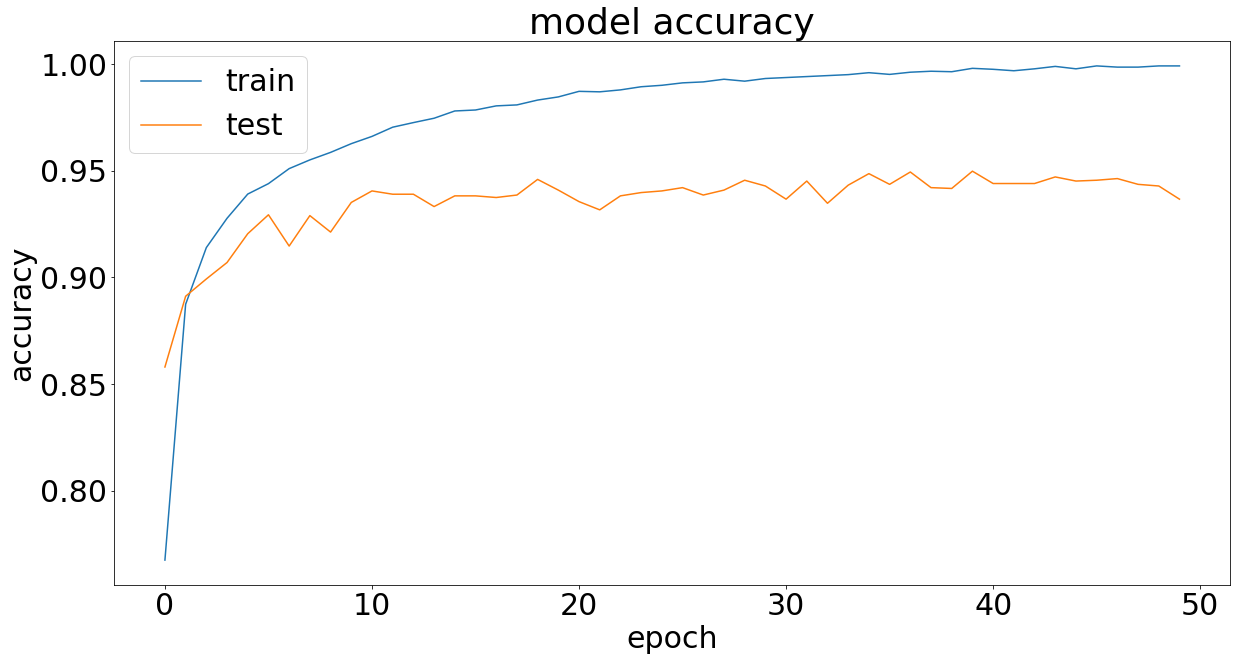

In [78]:
print(MobileNet_history.history.keys())
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(MobileNet_history.history['categorical_accuracy'])
plt.plot(MobileNet_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

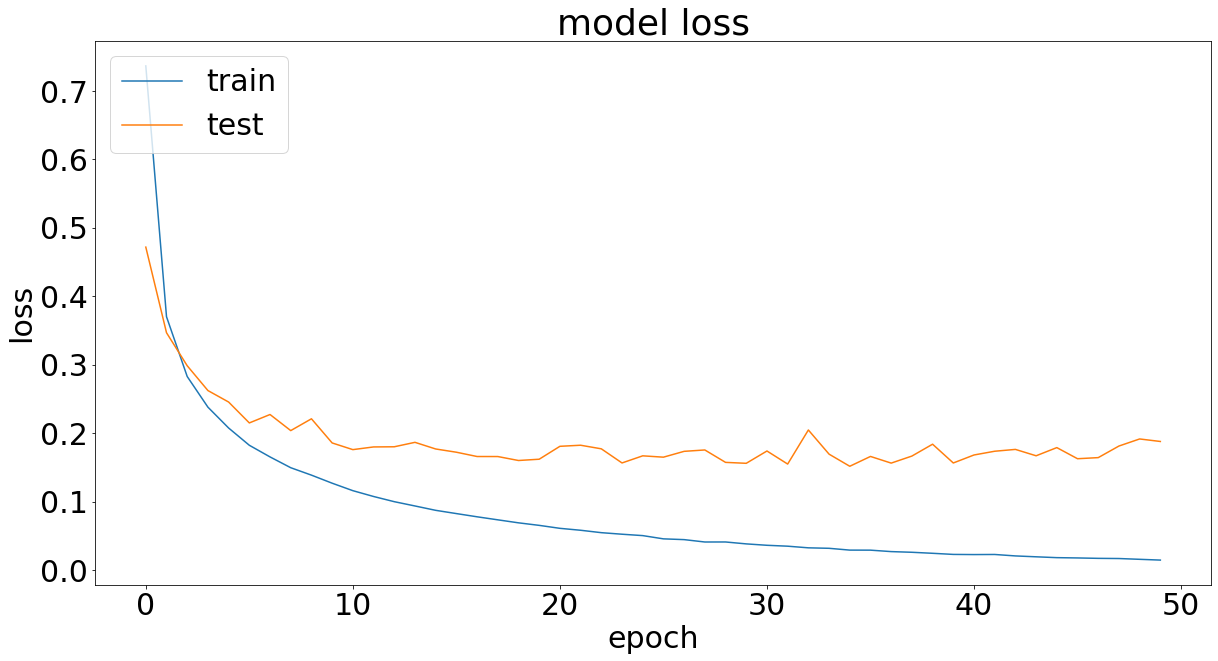

In [77]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(MobileNet_history.history['loss'])
plt.plot(MobileNet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# There is no need of Fine Tuning in this case as the validation accuracy is already very good

## Save the Mobilenet Model

In [60]:
Resnet_model.save('MobileNet_model.h5')

C:\Users\Tufail\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Xception Model

In [16]:
Xception_base_model = keras.applications.Xception(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

In [17]:
Xception_base_model.trainable = False

In [18]:
inputs = keras.Input(shape=(256, 256, 3))
# Separately from setting trainable on the model, we set training to False 
x =Xception_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes,activation='softmax')(x)
Xception_model = keras.Model(inputs, outputs)

In [19]:
Xception_model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [20]:
Xception_history=Xception_model.fit(X_train, Y_train, epochs=40, verbose=1,batch_size=10 ,validation_data=(X_valid, Y_valid))

Epoch 1/40
881/881 [==============================] - 53s 57ms/step - loss: 3.2307 - categorical_accuracy: 0.5925 - val_loss: 2.5894 - val_categorical_accuracy: 0.6246
Epoch 2/40
881/881 [==============================] - 50s 57ms/step - loss: 1.7342 - categorical_accuracy: 0.7232 - val_loss: 2.8057 - val_categorical_accuracy: 0.6759
Epoch 3/40
881/881 [==============================] - 50s 57ms/step - loss: 1.6672 - categorical_accuracy: 0.7517 - val_loss: 1.5268 - val_categorical_accuracy: 0.7515
Epoch 4/40
881/881 [==============================] - 50s 57ms/step - loss: 1.3997 - categorical_accuracy: 0.7834 - val_loss: 1.5819 - val_categorical_accuracy: 0.7542
Epoch 5/40
881/881 [==============================] - 50s 57ms/step - loss: 1.4030 - categorical_accuracy: 0.7967 - val_loss: 1.3812 - val_categorical_accuracy: 0.7978
Epoch 6/40
881/881 [==============================] - 50s 57ms/step - loss: 1.3545 - categorical_accuracy: 0.8085 - val_loss: 1.7277 - val_categorical_accuracy:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


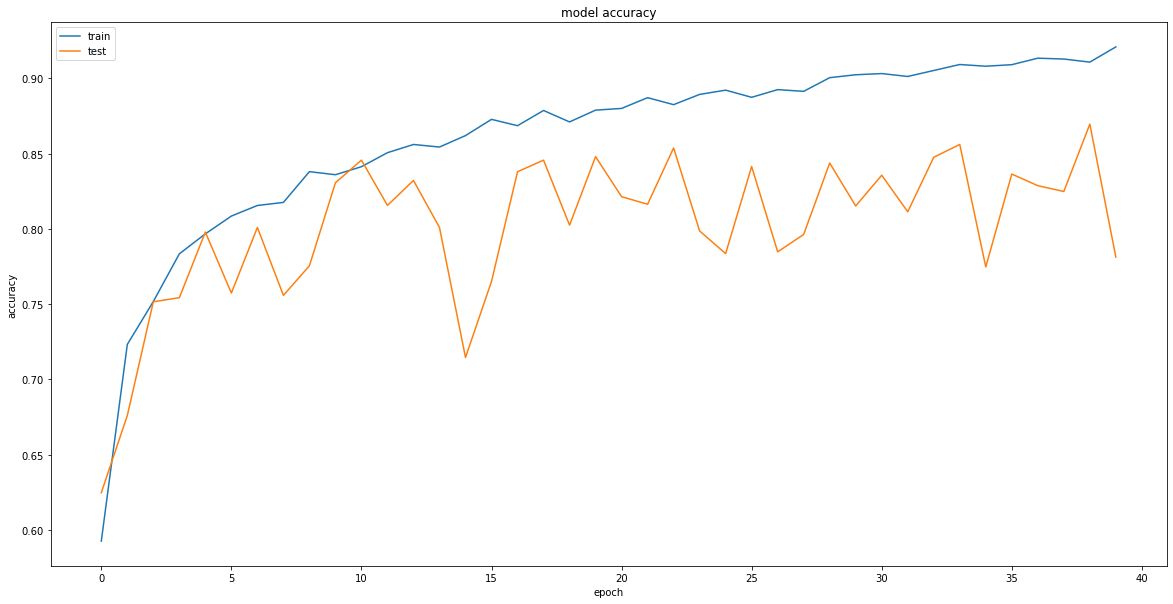

In [21]:
print(Xception_history.history.keys())
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(Xception_history.history['categorical_accuracy'])
plt.plot(Xception_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

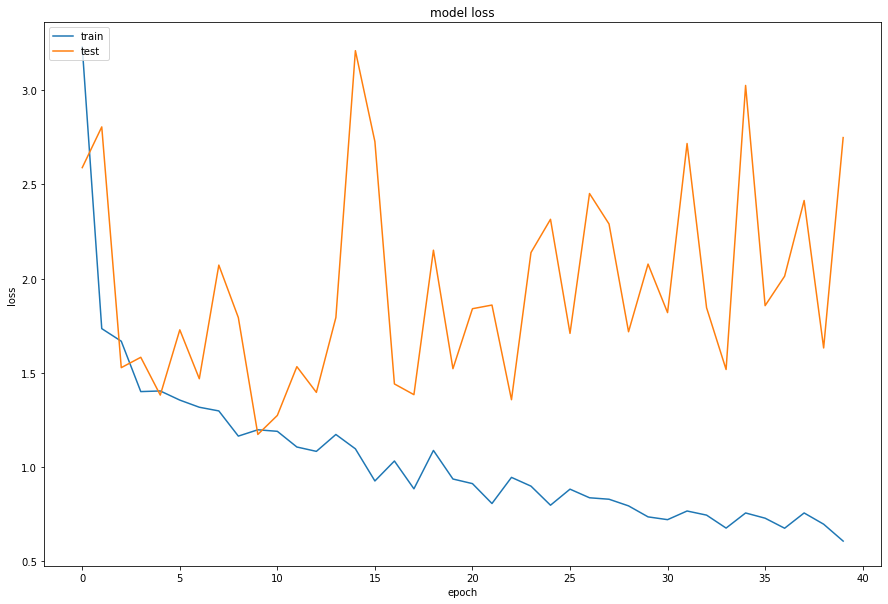

In [22]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(Xception_history.history['loss'])
plt.plot(Xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save the Xception Model

In [23]:
Xception_model.save('Xception_model.h5')

C:\Users\Tufail\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [12]:
Xception_model=keras.models.load_model('Xception_model.h5')

In [13]:
Xception_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
Xception_history=Xception_model.fit(X_train, Y_train, epochs=40, verbose=1,batch_size=10 ,validation_data=(X_valid, Y_valid))

Epoch 1/40
881/881 [==============================] - 76s 75ms/step - loss: 0.2902 - categorical_accuracy: 0.9505 - val_loss: 1.2844 - val_categorical_accuracy: 0.8754
Epoch 2/40
881/881 [==============================] - 66s 75ms/step - loss: 0.1181 - categorical_accuracy: 0.9726 - val_loss: 1.2539 - val_categorical_accuracy: 0.8773
Epoch 3/40
881/881 [==============================] - 66s 75ms/step - loss: 0.1071 - categorical_accuracy: 0.9743 - val_loss: 1.2361 - val_categorical_accuracy: 0.8804
Epoch 4/40
881/881 [==============================] - 65s 74ms/step - loss: 0.1026 - categorical_accuracy: 0.9752 - val_loss: 1.2275 - val_categorical_accuracy: 0.8804
Epoch 5/40
881/881 [==============================] - 65s 74ms/step - loss: 0.0984 - categorical_accuracy: 0.9752 - val_loss: 1.2303 - val_categorical_accuracy: 0.8804
Epoch 6/40
881/881 [==============================] - 66s 75ms/step - loss: 0.0941 - categorical_accuracy: 0.9766 - val_loss: 1.2224 - val_categorical_accuracy:

In [15]:
Xception_model.save('Xception_model_final.h5')

C:\Users\Tufail\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# VGG16

In [11]:
VGG16_base_model = keras.applications.VGG16(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

In [12]:
VGG16_base_model.trainable = False

In [13]:
inputs = keras.Input(shape=(256, 256, 3))
# Separately from setting trainable on the model, we set training to False 
x =VGG16_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes,activation='softmax')(x)
VGG16_model = keras.Model(inputs, outputs)

In [14]:
VGG16_model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

In [15]:
VGG16_history=VGG16_model.fit(X_train, Y_train, epochs=30, verbose=1,batch_size=10 ,validation_data=(X_valid, Y_valid))

Epoch 1/30
881/881 [==============================] - 69s 70ms/step - loss: 0.4207 - categorical_accuracy: 0.8871 - val_loss: 0.0972 - val_categorical_accuracy: 0.9703
Epoch 2/30
881/881 [==============================] - 59s 67ms/step - loss: 0.0553 - categorical_accuracy: 0.9839 - val_loss: 0.0546 - val_categorical_accuracy: 0.9819
Epoch 3/30
881/881 [==============================] - 60s 68ms/step - loss: 0.0301 - categorical_accuracy: 0.9913 - val_loss: 0.0425 - val_categorical_accuracy: 0.9877
Epoch 4/30
881/881 [==============================] - 60s 68ms/step - loss: 0.0182 - categorical_accuracy: 0.9960 - val_loss: 0.0352 - val_categorical_accuracy: 0.9888
Epoch 5/30
881/881 [==============================] - 60s 68ms/step - loss: 0.0131 - categorical_accuracy: 0.9977 - val_loss: 0.0312 - val_categorical_accuracy: 0.9896
Epoch 6/30
881/881 [==============================] - 60s 68ms/step - loss: 0.0098 - categorical_accuracy: 0.9980 - val_loss: 0.0366 - val_categorical_accuracy:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


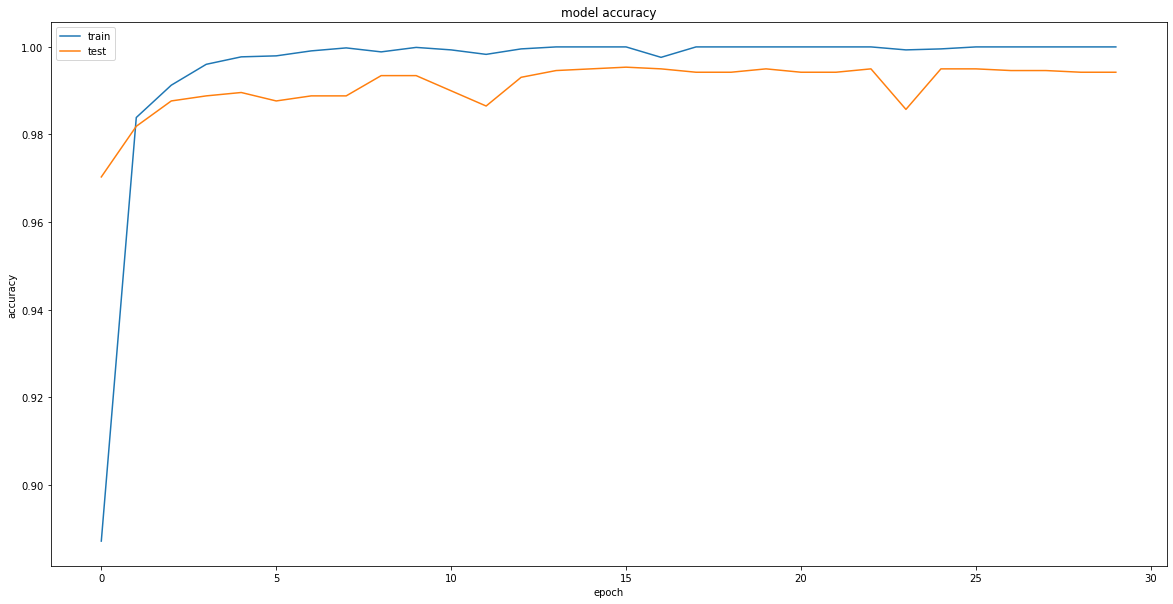

In [16]:
print(VGG16_history.history.keys())
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(VGG16_history.history['categorical_accuracy'])
plt.plot(VGG16_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

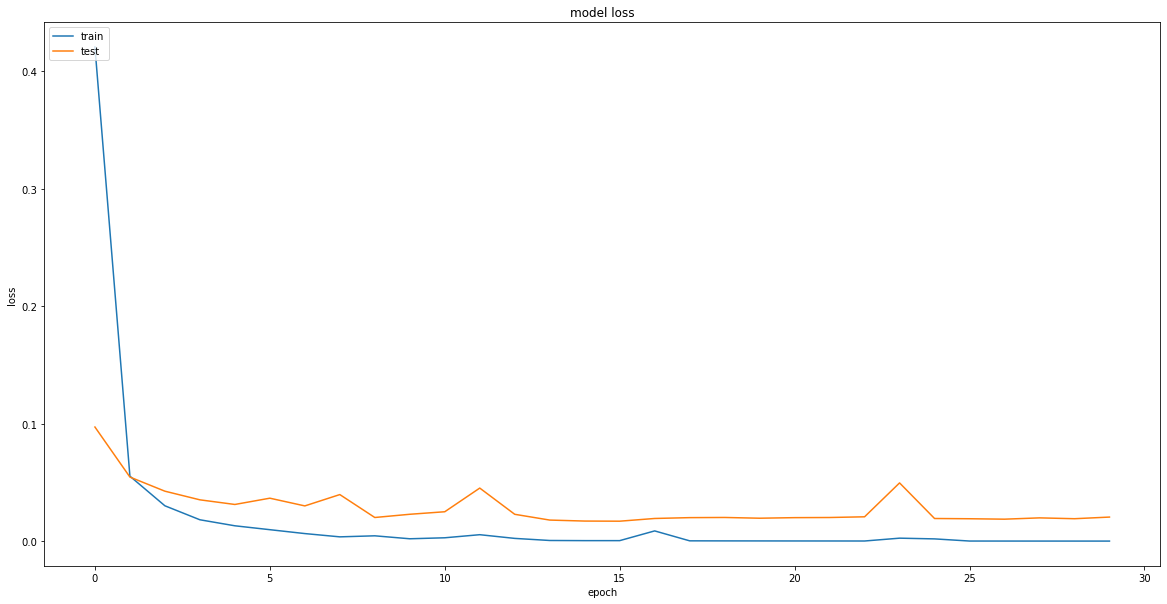

In [17]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(VGG16_history.history['loss'])
plt.plot(VGG16_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save the Model

In [19]:
VGG16_model.save('VGG16_model.h5')

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}